<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/BERT/BERTimbau_com_amostras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers

In [2]:

!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.


  Using cached torch-1.8.1-cp37-cp37m-manylinux1_x86_64.whl (804.1 MB)
  Using cached torchvision-0.9.1-cp37-cp37m-manylinux1_x86_64.whl (17.4 MB)
  Using cached torchaudio-0.8.0-cp37-cp37m-manylinux1_x86_64.whl (1.9 MB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.8.1, torchaudio==0.8.0 and torchvision==0.9.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.8.1
    torchvision 0.9.1 depends on torch==1.8.1
    torchaudio 0.8.0 depends on torch==1.8.0

To fix this you could try to

In [3]:
!nvidia-smi

Sat Aug 21 20:26:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from google.colab import files, drive
import io, os

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef
import seaborn as sns

### Carregando tokens e vocabulário do BERTimbau

In [5]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
tokenizer

PreTrainedTokenizerFast(name_or_path='neuralmind/bert-base-portuguese-cased', vocab_size=29794, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

### Preparando DataSet
https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

In [6]:
#!rm *.csv
#!!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/train.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/valid.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/test.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/miscelanea.csv
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks
path = '/gdrive/My Drive/Colab Notebooks'
KEY='4/1AX4XfWjFfXOpQF_Lhhwz8Sp5DTauJAEXNDQjx66Khyme5ASsCvDLtcqsBX0'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks


In [ ]:
#%cd amostra_news_integrada
#!unzip amostra_news_integrada-20210815T184936Z-001.zip
#!ls -lh
#!ls  amostra_news_integrada/amostra_2
#!mkdir bertimbau_all_categ


In [ ]:
#!mkdir ./bertimbau_all_categ/amostra_4


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
source_folder = './amostra_news_integrada/amostra_' #'/content'
destination_folder = './bertimbau_resp' #'/content'


In [9]:
!ls 

 amostra_news_integrada		       'Cópia de BERTimbau_Testes.ipynb'
 artigosWikibr.ipynb		        figuras
 BERTimbau_com_amostras.ipynb	        news_integradas.csv
 bertimbau_resp			        ResultadosExperimentos.ipynb
'Cópia de BERTimbau_Testes (1).ipynb'   Untitled
'Cópia de BERTimbau_Testes (2).ipynb'   Untitled1.ipynb
'Cópia de BERTimbau_Testes (3).ipynb'


In [10]:
#https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
#Model hyper-parameter
MAX_SEQ_LEN = 256 #limita os artigos em 128 tokens. BERTimbau base é limitado em 512 tokens por texto.
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
bs = 4
lr = 1e-6



# Fields - use_vocab=False  e tokenizer.encode permite que utilizemos os tokens do BERTimbau.
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field),('label', label_field)]





In [11]:
def tokenizaAmostra(source_folder, fields=fields):
  # TabularDataset
  train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                            test='test.csv', format='CSV', fields=fields, skip_header=True)
  # Iterators

  train_iter = BucketIterator(train, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  valid_iter = BucketIterator(valid, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  test_iter = Iterator(test, batch_size=bs, device=device, train=False, shuffle=False, sort=False)
  return [train_iter, valid_iter, test_iter]



In [ ]:
#print(vars(train[0]))
#print(vars(valid[0]))
#print(vars(test[0]))

## Modelo

In [12]:
'''É preciso informar o número de labels '''
class BERT(nn.Module):

    def __init__(self, qtd_categories):
        super(BERT, self).__init__()

        options_name = "bert-base-portuguese-cased"
        self.encoder = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',num_labels=qtd_categories )

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea



## Treinamento

In [13]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def create_directory(path, directory):
  try:
    os.makedirs(path + '/' + directory)
  except FileExistsError:
    # directory already exists
    pass

In [14]:
# Training Function
'''criterion = nn.BCELoss() é BinaryCrossEntropy é a função de perda para targets binarios. Como o nosso alvo possui
muitas classes troque a função de perda para nn.CrossEntropyLoss() '''

def train(model,
          optimizer,
          train_loader ,
          valid_loader ,
          eval_every ,
          file_path ,
          criterion = nn.CrossEntropyLoss(), #nn.BCELoss(),
          num_epochs = 5,
          best_valid_loss = float("Inf")):
    
    
    print('1 - inicializando variávies')
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    print('1 - inicializando treinamento')
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            #print('label size:', labels.size())
            #print('label:', labels)
            labels = labels.to(device)
            text = text.type(torch.LongTensor) 
            #print('text:', text.size())
            text = text.to(device)
            #print('treina...')
            output = model(text, labels)
            #print('fim treino...')
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text,labels), _ in valid_loader:
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    

In [1]:
device

NameError: ignored

In [15]:
%%time
qtd_categories=[32]
#token_train, token_valid, token_test = [],[],[]
id_planilha = [7_2]
dataset = [1]
for idx, (id_, amostra) in enumerate(zip(id_planilha,dataset)):
  create_directory(destination_folder,str(id_))
  file_path = destination_folder + "/"+str(id_)
  print(file_path)
  model = BERT(qtd_categories=qtd_categories[idx]).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  inicio = datetime.now()
  print('Treinando amostra:', amostra, 'inicio:', inicio)
  tokens = tokenizaAmostra(source_folder+str(amostra))
  #token_train.append(tokens[0])
  #token_valid.append(tokens[1])
  #token_test.append(tokens[2])
  train(model=model, 
      optimizer=optimizer,
      num_epochs=10,
      train_loader=tokens[0],
      valid_loader=tokens[1],
      eval_every=len(tokens[0]) // 2,
      file_path=file_path)
  print('Duracao:', datetime.now()-inicio)

./bertimbau_resp/72


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 1 inicio: 2021-08-21 20:26:43.339021
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/10], Step [320/6400], Train Loss: 3.4755, Valid Loss: 3.4725
Model saved to ==> ./bertimbau_resp/72/model.pt
Model saved to ==> ./bertimbau_resp/72/metrics.pt
Epoch [1/10], Step [640/6400], Train Loss: 3.4475, Valid Loss: 3.4235
Model saved to ==> ./bertimbau_resp/72/model.pt
Model saved to ==> ./bertimbau_resp/72/metrics.pt
Epoch [2/10], Step [960/6400], Train Loss: 3.3816, Valid Loss: 3.3637
Model saved to ==> ./bertimbau_resp/72/model.pt
Model saved to ==> ./bertimbau_resp/72/metrics.pt
Epoch [2/10], Step [1280/6400], Train Loss: 3.3460, Valid Loss: 3.3109
Model saved to ==> ./bertimbau_resp/72/model.pt
Model saved to ==> ./bertimbau_resp/72/metrics.pt
Epoch [3/10], Step [1600/6400], Train Loss: 3.2637, Valid Loss: 3.2638
Model saved to ==> ./bertimbau_resp/72/model.pt
Model saved to ==> ./bertimbau_resp/72/metrics.pt
Epoch [3/10], Step [1920/6400], Train Loss: 

In [ ]:
#!ls ./amostra_news_integrada/

#!rm  ./bertimbau_all_categ/amostra_4/*.*

!du -sh

793M	.


## Valor da função LOSS na descida do gradiente 
por id de experimento registrado na planilha de controle

Model loaded from <== ./bertimbau_resp/1/metrics.pt


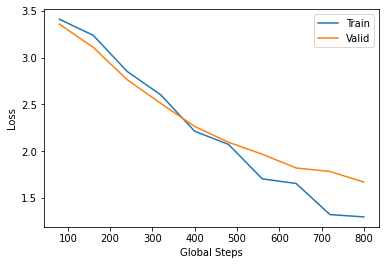

Model loaded from <== ./bertimbau_resp/7/metrics.pt


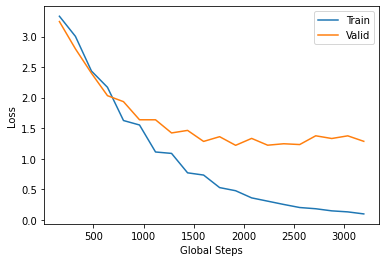

Model loaded from <== ./bertimbau_resp/71/metrics.pt


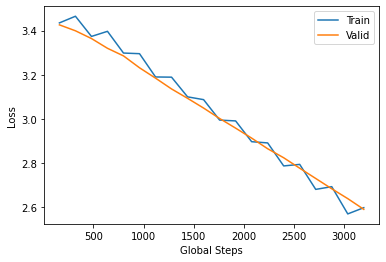

Model loaded from <== ./bertimbau_resp/72/metrics.pt


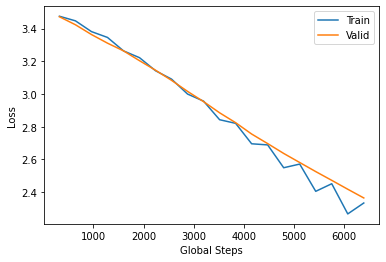

In [16]:
id_planilha = [1,7,71,72]
for id_ in id_planilha:
  file_path = destination_folder + "/"+str(id_)
  train_loss_list, valid_loss_list, global_steps_list = load_metrics(file_path + '/metrics.pt')
  plt.plot(global_steps_list, train_loss_list, label='Train')
  plt.plot(global_steps_list, valid_loss_list, label='Valid')
  plt.xlabel('Global Steps')
  plt.ylabel('Loss')
  plt.title = 'Resultado do Treino id ' + str(id_)
  plt.legend()
  plt.show() 

### Avaliação
* https://towardsdatascience.com/evaluating-categorical-models-e667e17987fd
* https://towardsdatascience.com/evaluating-categorical-models-ii-sensitivity-and-specificity-e181e573cff8
* https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5
* https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872
* https://towardsdatascience.com/matthews-correlation-coefficient-when-to-use-it-and-when-to-avoid-it-310b3c923f7e
* https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2 
*https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
* https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c
* https://thedatascientist.com/performance-measures-cohens-kappa-statistic/
* Material de aula do Professor André
* Material do curso MicroSoft
* Predictive Accuracy: A Misleading Performance Measure for Highly Imbalanced Data (sas_metrics.pdf) Paper 942-2017 (Josephine S Akosa, Oklahoma State University)


VP = VERDADEIRO POSITIVO<br>
VN = VERDADEIRO NEGATIVO<br>
FP = FALSO POSITIVO<br>
FN = FALSON NEGATIVO<br>
TVP = TAXA DE VERDADEIRO POSITIVO<br>
TVN = TAXA DE VERDADEIRO NEGATIVO<br>
TFP = TAXA DE FALSO POSITIVO<br>
TFN = TAXA DE FALSO NEGATIVO<br>

Métricas utilizadas:<br>

* **Acurácia:** proporção de classificações corretas feitas pelo modelo.<br>
        Acurácia = (VP + VN)/(VP+VN+VP+VN)<br>

* **Precisão:** proporção correta de classificação feita para uma determinada classe.<br>
        Precisão = (VP)/(VP + FP)

* **Revocação ou Sensibilidade:** proporção de classificações corretas de VP feitas para uma determinada classe considerando todas as instâncias do dataset de testes.<br>
      Revocação = TVP = (VP)/(VP+FN)

* **Especificidade:** proporção de classificações corretas de VN feitas para uma determinada classe considerando todas as instâncias do dataset de testes.
      Especificidade = TVN = (VN)/(VN + FP)

* **Suporte:** quantidade de instâncias de uma determinada classe no dataset de testes.

**Para o DataSet 3 - dados desbalanceados**

* **F1 é a média harmônica da precisão e da revocação.<br>

      F1 = (2 * VP) / (2 * VP + FP + FN)
* **MCC:** é o coeficiente de correlação Matthews que é utilizado para classes com tamanhos diferentes. Possui escala entre -1 e 1, sendo que 1 indica uma perfeita predição, 0 representa uma predição aleatória e -1 indica discordância total dos valores preditos e os valores verdadeiros.  

      MCC = (VP*VN - FP*FN) / (SQRT(VP+FP)*(VP+FN)*(VN+FP)*(VN+FN)
      

* **Kappa Score - Cohen's Kappa Coefficient** informa quão melhor o classificador está se saindo em relação ao desempenho de um classificador que simplesmente adivinha aleatoriamente de acordo com a frequência de cada classe:

      k = (Po - Pe)/(1-Pe) = 1 - (1 - Po)/(1 - Pe)

Po é a concordancia observada e Pe é a concordância esperada. O Kappa de Cohen é sempre menor ou igual a 1, sendo que valores menores ou iguais a zero indicam que o classificador é inútil. Quanto mais próximo de 1, indica que o classificador gera uma concordância quase perfeita.

* **Média Geométrica (G-mean)** é uma métrica que mede o equilíbrio entre o desempenho de classificação tanto na classe majoritária quanto na minoritária. Um índice baixo é uma indicação de mau desempenho na classificação dos casos positivos, mesmo que os casos negativos sejam corretamente classificados como tal. Ela é importante para prever o sobreajustamento da classe negativa e o subajustamento da classe positiva. Como nosso dataset não possui classes binárias, a fórmula de cálculo será como se segue (material de aula do Prof. André):

      G-mean = $(\pi_{i=1}^{c}Revocacao_{i})^{1/c}$ 




  



In [17]:
def calcula_especificidade(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = np.sum(VN)/(np.sum(VN) + np.sum(FP))
  return TVN

In [18]:
def calcula_especificidade_porClasse(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = (VN)/(VN + FP)
  return TVN

In [19]:
def calcula_GMean_multiclass(revocacao):
   revoc = np.array(revocacao)
   GMean = revoc.prod()**(1.0/len(revoc))
   return GMean  
   

In [20]:
def elabora_relatorio_metricas(report, matriz_confusao):
  espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
  dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
  dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
  dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
  dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
  dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
  metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
  df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
  df['support'] = df['support'].astype('int')
  return df



In [21]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []


    #obtem os valores preditos e os valores de teste
    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:
                labels = labels.type(torch.LongTensor)  #carrega as classes para uma estrutura pytorch         
                labels = labels.to(device)  #carrega a estrutura pytorch para GPU (se houver, foi testado anteriormente)
                text = text.type(torch.LongTensor)    #carrega o texto para uma estrutura pytorch
                text = text.to(device)          #carrega a estrutura pytorch para GPU (se houver, foi testado anteriormente)
                output = model(text, labels)   #submete o texto e a label da classe ao modelo

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())  #obtem do pytorch de saída do modelo o valor predito.
                y_true.extend(labels.tolist()) #obtem do pytorch de teste  valor real.
    
    print('Classification Report:')
    n_classe = np.max(y_true)+1 #obtem o número de classes
    report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) #gera o relatório de métricas
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe)) #gera a matriz de confusao
    report = elabora_relatorio_metricas(report, cm) #inclui no relatorio a especificidade
    print(report)

    cohen_kappa = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
    ccmatheus = matthews_corrcoef(y_true, y_pred)
    
    print("Acurácia:",accuracy_score(y_true, y_pred))
    print('Acurácia balanceada:',balanced_accuracy_score(y_true, y_pred))
    print('GMean:', calcula_GMean_multiclass(report['recall']))
    print('Cohen Kappa Score:', cohen_kappa)
    print('Coef. Correlacao Matheus:', ccmatheus)
    
    
    
    #ax= plt.subplot()
    #sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    #ax.set_title('Confusion Matrix')
    #ax.set_xlabel('Predicted Labels')
    #ax.set_ylabel('True Labels')
    return report


In [23]:
#%%time    
qtd_categories=[32]
id_planilha = [72]
dataset = [1]
for idx, (id_, amostra) in enumerate(zip(id_planilha,dataset)):
      print('id_planilha:', id_)
      tokens = tokenizaAmostra(source_folder+str(amostra))
      best_model =BERT(qtd_categories=qtd_categories[idx]).to(device)
      load_checkpoint(destination_folder+"/"+str(id_) + '/model.pt', best_model)
      evaluate(best_model, tokens[2])

id_planilha: 72


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/72/model.pt
Classification Report:
          precision    recall  specificity  f1-score  support
0          0.666667  0.600000     0.990323  0.631579       10
1          0.500000  0.100000     0.996774  0.166667       10
2          0.705882  0.923077     0.983713  0.800000       13
3          0.625000  0.714286     0.990415  0.666667        7
4          0.466667  1.000000     0.974441  0.636364        7
5          0.333333  0.333333     0.987261  0.333333        6
6          0.500000  0.750000     0.980769  0.600000        8
7          0.750000  0.214286     0.996732  0.333333       14
8          0.714286  0.555556     0.993569  0.625000        9
9          0.571429  0.615385     0.980456  0.592593       13
10         1.000000  0.692308     1.000000  0.818182       13
11         0.769231  0.769231     0.990228  0.769231       13
12         0.375000  0.857143     0.968051  0.521739        7
13         0.666667  0.800000     0.987097  0.727273      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#!rm ./bertimbau_all_categ/amostra_4/*.*
#!du -sh
